In [1]:
!pip install segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency r

In [2]:
# https://platform.olimpiada-ai.ro/problems/56

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.transforms import v2

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
train = pd.read_csv("/kaggle/input/pokemon/train.csv")
test = pd.read_csv("/kaggle/input/pokemon/test.csv")

train.shape, test.shape

((647, 3), (162, 2))

In [5]:
train['Type'].value_counts()

Type
Water       93
Normal      85
Grass       59
Bug         53
Psychic     47
Fire        44
Rock        40
Electric    30
Poison      28
Ground      25
Steel       24
Ghost       22
Dragon      21
Dark        21
Fighting    19
Ice         18
Fairy       16
Flying       2
Name: count, dtype: int64

In [6]:
train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Type'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

train.shape, valid.shape

((517, 3), (130, 3))

In [7]:
classes = train['Type'].value_counts().index.tolist()
class2idx = {v: i for i, v in enumerate(classes)}
idx2class = {i: v for i, v in enumerate(classes)}

classes_to_count = train['Type'].value_counts().to_dict()
class_weights = [len(train) / (len(classes)*v) for v in classes_to_count.values()]

print(classes)

['Water', 'Normal', 'Grass', 'Bug', 'Psychic', 'Fire', 'Rock', 'Electric', 'Poison', 'Ground', 'Steel', 'Ghost', 'Dark', 'Dragon', 'Fighting', 'Ice', 'Fairy', 'Flying']


In [8]:
class PokemonDataset(Dataset):
    def __init__(self, df, is_test=False, transform=None):
        self.df = df
        self.is_test = is_test
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(os.path.join('/kaggle/input/pokemon', self.df.loc[idx, 'ImagePath']))
        if self.transform is not None:
            img = self.transform(img)
            
        if self.is_test:
            return img

        label = torch.tensor(class2idx[self.df.loc[idx, 'Type']], dtype=torch.long)
        
        return img, label

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(distortion_scale=0.5, p=1.0),
    v2.RandomRotation(degrees=(0, 180)),
    v2.Normalize(mean=[0.485, 0.456, 0.406, 0.], std=[0.229, 0.224, 0.225, 1.]),
])

train_ds = PokemonDataset(train, transform=transform)
valid_ds = PokemonDataset(valid, transform=transform)

BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
class PokemonClassifier(nn.Module):
    def __init__(self, base_model, n_classes=18):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_classes*120*120, 512),
            nn.ReLU(),
            nn.Linear(512, n_classes)
        )
    def forward(self, x):
        return self.classifier(self.base_model(x))

base_model = smp.Unet(
    encoder_name='senet154',
    encoder_weights='imagenet',
    in_channels=4,
    classes=len(classes)
)

model = PokemonClassifier(base_model).to(device)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/461M [00:00<?, ?B/s]

In [10]:
epochs = 10
log_rate = 1

train_losses, valid_losses, valid_accs = [], [], []

for epoch in tqdm(range(epochs), desc='Training'):
    model.train()
    running_train_loss, i = 0, 0
    for X_batch, y_batch in (pbar := tqdm(train_loader, desc='Train DataLoader', leave=False)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = loss_fn(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        running_train_loss += loss.item()
        pbar.set_postfix({'loss': f'{running_train_loss/i:.5f}'})
    
    train_losses.append(running_train_loss/i)

    if (epoch+1)%log_rate==0:
        print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {running_train_loss/i:.5f}')

    model.eval()
    running_valid_loss, i = 0, 0
    correct, total = 0, 0
    for X_batch, y_batch in (pbar := tqdm(valid_loader, desc='Valid DataLoader', leave=False)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        with torch.no_grad():
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            probs = torch.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)

        correct += (preds==y_batch).sum().item()
        total += len(preds)
        
        i += 1
        running_valid_loss += loss.item()
        pbar.set_postfix({'loss': f'{running_valid_loss/i:.5f}', 'acc': f'{correct/total:.5f}'})
    
    valid_losses.append(running_valid_loss/i)
    valid_accs.append(correct/total)

    if (epoch+1)%log_rate==0:
        print(f'Valid Loss: {running_valid_loss/i:.5f} | Valid Acc: {correct/total:.5f}')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1/10 | Train Loss: 6.09704


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 4.98165 | Valid Acc: 0.07692


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2/10 | Train Loss: 3.11061


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 3.09665 | Valid Acc: 0.10000


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 3/10 | Train Loss: 2.88227


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 3.08938 | Valid Acc: 0.14615


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 4/10 | Train Loss: 2.76236


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 3.72154 | Valid Acc: 0.10769


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 5/10 | Train Loss: 2.68053


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 3.47371 | Valid Acc: 0.12308


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 6/10 | Train Loss: 2.68676


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 2.87685 | Valid Acc: 0.10769


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 7/10 | Train Loss: 2.57639


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 3.17206 | Valid Acc: 0.13077


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 8/10 | Train Loss: 2.58254


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 3.01826 | Valid Acc: 0.13077


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 9/10 | Train Loss: 2.47718


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 2.77291 | Valid Acc: 0.16923


Train DataLoader:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 10/10 | Train Loss: 2.51143


Valid DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Valid Loss: 2.98390 | Valid Acc: 0.14615


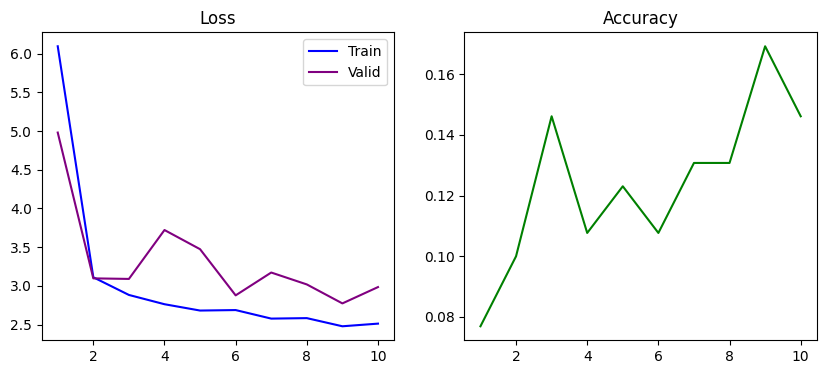

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(1, len(train_losses)+1), train_losses, c='blue', label='Train')
plt.plot(range(1, len(valid_losses)+1), valid_losses, c='purple', label='Valid')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(1, len(valid_accs)+1), valid_accs, c='green')

plt.show()

In [12]:
test_ds = PokemonDataset(test, is_test=True, transform=v2.ToTensor())

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
predictions = []

for X_batch in (pbar := tqdm(test_loader, desc='Test DataLoader')):
    X_batch = X_batch.to(device)
    with torch.no_grad():
        output = model(X_batch).cpu()
        probs = torch.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)

    predictions.extend(preds.tolist())

subm = pd.DataFrame({
    'SampleID': test['SampleID'],
    'Type': list(map(idx2class.get, predictions))
})

subm.to_csv("submission.csv", index=False)

subm.head()

Test DataLoader:   0%|          | 0/6 [00:00<?, ?it/s]

,SampleID,Type
0,699,Normal
1,297,Fire
2,228,Ground
3,337,Ground
4,538,Ground


In [14]:
subm['Type'].value_counts()

Type
Ground     86
Normal     35
Psychic    24
Fire        9
Dark        8
Name: count, dtype: int64